# TensorFlow 
## Deep Neural Network for Classification of Fashion-MNIST Dataset
by [Sameer Kumar](https://sites.google.com/view/bvsk35/home?authuser=0)

### Introduction
Here I have created a neural network for a classification problem based on my previous implementation in `1-MNIST-Classification-Simple` folder on my GitHub (most of the explanation from previous code has been kept as it is). Problem here in our hand is classification of Fashion-MNIST dataset with a simple feedforward fully connected neural network. Loading the dataset will be simple and same as MNIST Dataset.

### Why Fashion-MNIST?
This explanation has been taken from these [people](https://github.com/zalandoresearch/fashion-mnist) who made this dataset. Thank you for your generous contribution for the scientific society. 

The original [MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains a lot of handwritten digits. Members of the AI/ML/Data Science community love this dataset and use it as a benchmark to validate their algorithms. In fact, MNIST is often the first dataset researchers try. *"If it doesn't work on MNIST, it **won't work** at all"*, they said. *"Well, if it does work on MNIST, it may still fail on others."* 

### Serious Machine Learning Researchers

Serious ML researchers are talking about replacing MNIST. Here are some good reasons:

- **MNIST is too easy.** Convolutional nets can achieve 99.7% on MNIST. Classic machine learning algorithms can also achieve 97% easily. Check out [zalandoresearch's side-by-side benchmark for Fashion-MNIST vs. MNIST](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/), and read "[Most pairs of MNIST digits can be distinguished pretty well by just one pixel](https://gist.github.com/dgrtwo/aaef94ecc6a60cd50322c0054cc04478)."
- **MNIST is overused.** In [this April 2017 Twitter thread](https://twitter.com/goodfellow_ian/status/852591106655043584), Google Brain research scientist and deep learning expert Ian Goodfellow calls for people to move away from MNIST.
- **MNIST can not represent modern CV tasks**, as noted in [this April 2017 Twitter thread](https://twitter.com/fchollet/status/852594987527045120), deep learning expert/Keras author François Chollet.

**Supress warnings**: When calling *tensorflow* module in Juptyer Notebook it raises warning of *h5py* compliation against wrong version of *hdf5* in Windows OS when using Anaconda. Even though internally all versions are correct this might be due to wrong version written recipe file. 

**TLDR;** Warnings can be ignored (since everything works properly) and to suppress the warning I am calling this function. But it is not necessary. If you want to see warnings once (which happens by default in Juptyer notebook) uncomment the third line below and comment the second line. 

In [1]:
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

### Imports
Import all the required modules and *Load_MNIST_Data* has a class *MNIST* written by me which has all basic helper functions required. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from Load_MNIST_Data import MNIST

### Load Data
Load the MNIST data using *prep_data* which outputs training set, validation set and test set scaled based on the scaling defined by the user. Default is 'MMS': MinMaxScaler and other option is 'SS': StandardScaler. Use *one_hot_encoded* to generate the one hot encoded vectors for training purposes. 

In [3]:
data = MNIST(scaling='MMS')
train_img, train_label, val_img, val_label, test_img, test_label = data.prep_data('train-images-idx3-ubyte.gz', 
                                                                                  'train-labels-idx1-ubyte.gz', 
                                                                                  't10k-images-idx3-ubyte.gz', 
                                                                                  't10k-labels-idx1-ubyte.gz')
hot_label_train, hot_label_val, hot_label_test = data.one_hot_encoded(train_label, val_label, test_label)

The MNIST data-set has now been loaded and consists of 70000 images and labels for the images. The dataset is split into 3 mutually exclusive subsets.

In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(data.num_train))
print("- Validation-set:\t{}".format(data.num_val))
print("- Test-set:\t\t{}".format(data.num_test))

Size of:
- Training-set:		55000
- Validation-set:	5000
- Test-set:		10000


Copy some of the data-dimensions for convenience.

In [10]:
# The images are stored in one-dimensional arrays of this length.
img_size_flat = data.img_size_flat

# Tuple with height and width of images used to reshape arrays.
img_shape = data.img_shape

# Number of classes, one class for each of 10 digits.
num_classes = data.num_classes

Create a dictionary which holds the named labels for each numeric value. Remember each label corresponds to some clothing garment. 

In [11]:
# Dictionary containing information about each class
label_dict = {'0': 'T-shirt/top', '1': 'Trouser', '2': 'Pullover', '3': 'Dress', '4': 'Coat', 
              '5': 'Sandal', '6': 'Shirt', '7': 'Sneaker', '8': 'Bag', '9': 'Ankle boot'}

### One-Hot Encoding
The output data is loaded as both integer labels and One-Hot encoded arrays. This means the labels have been converted from a single integer to a vector whose length equals the number of possible classes. All elements of the vector are zero except for the $i^{th}$ element which is 1 and means the class is $i$. For example, the One-Hot encoded labels for the first 5 images in the test-set are:

In [6]:
print('One-Hot Encoded vectors: \n', hot_label_test[:5, :])

One-Hot Encoded vectors: 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


We also need the classes as integers for various comparisons and performance measures. These can be found from the One-Hot encoded arrays by taking the index of the highest element using the `np.argmax()` function. But this has already been done when the dataset was loaded, so we can see the labels for the first five images in the test set. Compare these to the One-Hot encoded arrays above.

In [7]:
print('Labels: \n', test_label[:5])

Labels: 
 [9 2 1 1 6]


### Helper function for Plotting
This function is used to plot images in a NxN grid. Also added functionality to change the color map of the plots by changing the variable `color_map` sent as arguments to this function. 

In [12]:
def plot_images(images, cls_true, cls_pred=None, color_map='binary'):
    check = int(np.sqrt(images.shape[0]))
    try:
        assert check * check == images.shape[0] 
    except AssertionError:
        raise AssertionError("Input array first dimension must be square")
    
    if check != 1:
        # Create figure with nxn sub-plots.
        fig, axes = plt.subplots(check, check)
        fig.subplots_adjust(hspace=0.3, wspace=0.3)

        for i, ax in enumerate(axes.flat):
            # Plot image.
            ax.imshow(images[i].reshape(img_shape), cmap=color_map)

            # Show true and predicted classes.
            if cls_pred is None:
                string = str(cls_true[i])
                xlabel = "True: {0}".format(label_dict[string])
            else:
                string_1 = str(cls_true[i])
                string_2 = str(cls_pred[i])
                xlabel = "True: {0}, Pred: {1}".format(label_dict[string_1], label_dict[string_2])

            ax.set_xlabel(xlabel)

            # Remove ticks from the plot.
            ax.set_xticks([])
            ax.set_yticks([])
    else:
        fig, axes = plt.subplots()
        axes.imshow(images.reshape(img_shape), cmap=color_map)
        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true)
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true, cls_pred)

        axes.set_xlabel(xlabel)

        # Remove ticks from the plot.
        axes.set_xticks([])
        axes.set_yticks([])       
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see how does dataset looks
This images depends on which kind of scaling you are using. If you use 'SS' scaling then images look as if it has been smudged and if you use 'MMS' scaling then images look as if more crisp **People mostly use 'MMS' scaling** .

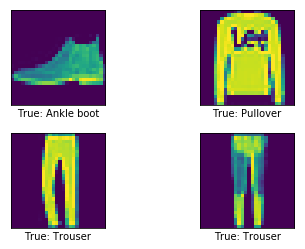

In [17]:
# Get the first images from the test-set.
images = test_img[0:4]

# Get the true classes for those images.
cls_true = test_label[0:4]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, color_map='viridis')

## TensorFlow Graph
The entire purpose of TensorFlow is to have a computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. TensorFlow can be more efficient than NumPy because TensorFlow knows the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time.

TensorFlow can also efficiently load tons of real world data present in storage drives (in the format of byte) and perform computations faster than NumPy. 

TensorFlow can also automatically calculate the gradients that are needed to optimize the variables of the graph so as to make the model perform better. This is because the graph is a combination of simple arithmetic expressions so the gradient of the entire graph can be calculated using the chain-rule for derivatives.

TensorFlow can also take advantage of multi-core CPUs as well as GPUs - and Google has even built special chips just for TensorFlow which are called TPUs (Tensor Processing Units) that are even faster than GPUs.

A TensorFlow graph consists of the following parts (and many more):
* Placeholder: variables used to feed input into the graph.
* Model variables: that are going to be optimized so as to make the model perform better.
* Model: which is essentially just a mathematical function that calculates some output given the input in the placeholder variables and the model variables.
* Cost: measure that can be used to guide the optimization of the variables.
* Optimization method: which updates the variables of the model.

In addition, the TensorFlow graph may also contain various debugging statements e.g. for logging data to be displayed using TensorBoard.

### Placeholder variables
Placeholder variables serve as the input to the graph that we may change each time we execute the graph. This is known as feeding the placeholder variables.

First we define the placeholder variable for the *input* *images*. This allows us to change the images that are input to the TensorFlow graph. This is a tensor, which just means that it is a multi-dimensional vector or matrix. The data-type is set to `float64` and the shape is set to `[None, img_size_flat]`, where None means that the tensor may hold an arbitrary number of images with each image being a vector of length `img_size_flat`.

In [18]:
X = tf.placeholder(name='Input', dtype=tf.float64, shape=[None, img_size_flat])

Next we have the placeholder variable for the **desired** *labels* of each image in the placeholder variable `X`. These are integers and the dimensionality of this placeholder variable is set to `[None]` which means the placeholder variable is a one-dimensional vector of arbitrary length.

In [19]:
y_true = tf.placeholder(name='Desired_Labels', dtype=tf.int64, shape=[None])

Finally, we have the placeholder variable for the **predicted** one-hot encoded labels associated with the images that were input in the placeholder variable `X`. The shape of this placeholder variable is `[None, num_classes]` which means it may hold an arbitrary number of them and each one-hot encoded labels is a vector of length num_classes which is 10 in this case.

In [20]:
y_true_hot = tf.placeholder(name='Desired_Output', dtype=tf.float64, shape=[None, num_classes])

### Variables to be optimized
Apart from the placeholder variables that were defined above and which serve as feeding input data into the model, there are also some model variables that must be changed by TensorFlow so as to make the model perform better on the training data.

The first variable that must be optimized is called weights and is defined here as a TensorFlow variable that must be initialized with zeros and whose shape is `[img_size_flat, num_classes]`, so it is a 2-dimensional tensor (or matrix) with `img_size_flat` rows and `num_classes columns`. The second variable that must be optimized is called biases and is defined as a 1-dimensional tensor (or vector) of length `num_classes`.

Each layer has it's own weights and bias.

### Model
This mathematical model feeds the images using the placeholder variable `X` to neural network. Where at each layer inputs are mulitplied with the `weights` and then `biases` are added. Finally activation function is applied component wise. 

For example at first hidden layer: The result is a matrix of shape `[num_images, num_classes]` because `X` has shape `[num_images, img_size_flat]` and `weights` has shape `[img_size_flat, num_classes]`, so the multiplication of those two matrices is a matrix with shape `[num_images, num_classes]` and then the `biases` vector is added to each row of that matrix. At last activation function is applied.

Neural network shown below has two hidden layers with 40 neurons per layer. Input layer will have `img_size_flat` no. of nodes (784) and output layer will have `num_classes` no. of nodes (10). ReLU is activation function hidden layers and softmax is acitvation function in last layer. Softmax activation gives out the probability of the input being in one of the ten classes. And max of all the probability will be taken as the predicted output by the neural network.  

In [21]:
# NN model
def create_model(X):
    
    # Create Weights
    W0 = tf.get_variable(name='W0', shape=[img_size_flat, 40], dtype=tf.float64, 
                             initializer=tf.contrib.layers.xavier_initializer())
    W1 = tf.get_variable(name='W1', shape=[40, 40], dtype=tf.float64, 
                             initializer=tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable(name='W2', shape=[40, num_classes], dtype=tf.float64, 
                             initializer=tf.contrib.layers.xavier_initializer())
    
    # Bias
    b0 = tf.get_variable(name='b0', shape=[1, 40], dtype=tf.float64, initializer=tf.constant_initializer(0.0))
    b1 = tf.get_variable(name='b1', shape=[1, 40], dtype=tf.float64, initializer=tf.constant_initializer(0.0))
    b2 = tf.get_variable(name='b2', shape=[1, num_classes], dtype=tf.float64, initializer=tf.constant_initializer(0.0))
    
    # List of all the variables
    weights = [W0, W1, W2]
    bias = [b0, b1, b2]
    activations = [tf.nn.relu, tf.nn.relu, tf.nn.softmax]
    
    # Forward Pass or create computation graph
    layer_output = X
    for W, b, phi in zip(weights, bias, activations):
        local_induced_fields = tf.matmul(layer_output, W)
        layer_output = phi(local_induced_fields + b)
    
    logits = local_induced_fields
    y_pred_hot = layer_output
    y_pred = tf.argmax(y_pred_hot, axis=1)
    
    return logits, y_pred_hot, y_pred

logits, y_pred_hot, y_pred = create_model(X)

### Cost-function to be optimized
To make the model better at classifying the input images, we must somehow change the variables for `weights` and `biases`. To do this we first need to know how well the model currently performs by comparing the predicted output of the model `y_pred` to the desired output `y_true`.

The **cross-entropy** is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the weights and biases of the model.

TensorFlow has a built-in function for calculating the cross-entropy. Note that it uses the values of the **logits** i.e., locally induced fields because it also calculates the softmax internally. TensorFlow class *locally induced fields* as *logits*. For more refer [TensorFlow-cross-entropy](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits_v2).

In [22]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y_true_hot)

We have now calculated the cross-entropy for each of the image classifications so we have a measure of how well the model performs on each image individually. But in order to use the cross-entropy to guide the optimization of the model's variables we need a single scalar value, so we simply take the average of the cross-entropy for all the image classifications.

In [23]:
cost = tf.reduce_mean(cross_entropy)

### Optimization method
Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the basic form of Gradient Descent where the step-size is set to 0.5.

In [24]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

### Performance measures
We need a few more performance measures to display the progress. Below: this is a vector of booleans whether the predicted class equals the true class of each image.

In [25]:
correct_prediction = tf.equal(y_pred, y_true)

This calculates the classification accuracy by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then calculating the average of these numbers.

In [26]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

### Create TensorFlow session
Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [27]:
def tf_reset():
    try:
        sess.close()
    except:
        pass
    return tf.Session()

In [28]:
sess = tf_reset()

### Initialize variables
The variables for `weights` and `biases` must be initialized before we start optimizing them.

In [29]:
# Initialize the variables
sess.run(tf.global_variables_initializer())

### Helper-function to perform optimization iterations
There are 55000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore use *Batch Stochastic Gradient Descent* which only uses a small batch of images in each iteration of the optimizer.

In [30]:
batch_size = 128

Function for performing a number of optimization iterations so as to gradually improve the `weights` and `biases` of the model. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.

In [31]:
# Run training
def optimize(iterations):
    for training_step in range(iterations):
        # get a random subset/batch of the training data
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        X_batch, y_true_batch, y_true_hot_batch = data.random_batch(train_img, train_label, hot_label_train, 
                                                                        batch_size=batch_size)

        # run the optimizer and get the mse
        _, cost_run = sess.run([optimizer, cost], feed_dict={X: X_batch, y_true_hot: y_true_hot_batch})

        # print the mse every so often
        if training_step % 100 == 0:
            print('{0:04d} mse: {1:.3f}'.format(training_step, cost_run))

### Helper-functions to show performance
Function for printing the classification accuracy on the test-set.

In [32]:
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = sess.run(accuracy, feed_dict={X: test_img, y_true: test_label, y_true_hot: hot_label_test})
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

Function for printing and plotting the confusion matrix using scikit-learn.

In [33]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = test_label
    
    # Get the predicted classifications for the test-set.
    cls_pred = sess.run(y_pred, feed_dict={X: test_img, y_true: test_label, y_true_hot: hot_label_test})

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

Function for plotting examples of images from the test-set that have been mis-classified.

In [35]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = sess.run([correct_prediction, y_pred],
                                    feed_dict={X: test_img, y_true: test_label, y_true_hot: hot_label_test})

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = test_img[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = test_label[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:4], cls_true=cls_true[0:4], cls_pred=cls_pred[0:4], color_map='viridis')

### Performance before any optimization
The accuracy on the test-set will be vary low around 10%. This is because the model has only been initialized and not optimized at all, so it always predicts that the image shows a zero digit.

In [36]:
print_accuracy()

Accuracy on test-set: 7.7%


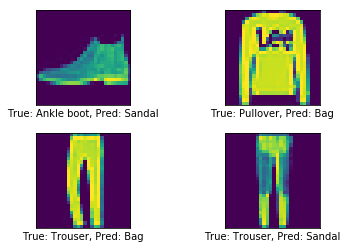

In [37]:
plot_example_errors()

### Performance after 1 optimization iteration
Already after a single optimization iteration, the model has increased its accuracy on the test-set significantly.

In [38]:
optimize(iterations=1)

0000 mse: 2.423


In [39]:
print_accuracy()

Accuracy on test-set: 12.8%


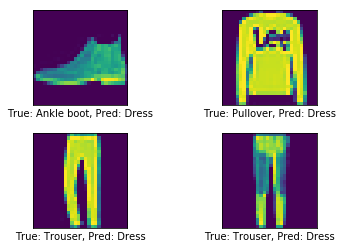

In [40]:
plot_example_errors()

### Performance after 10 optimization iterations

In [41]:
optimize(iterations=10)

0000 mse: 2.316


In [42]:
print_accuracy()

Accuracy on test-set: 21.9%


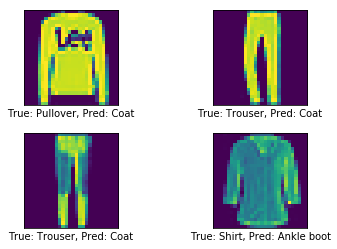

In [43]:
plot_example_errors()

### Performance after 1000 optimization iterations

In [44]:
optimize(iterations=1000)

0000 mse: 2.480
0100 mse: 0.916
0200 mse: 0.893
0300 mse: 0.520
0400 mse: 0.555
0500 mse: 0.617
0600 mse: 0.729
0700 mse: 0.502
0800 mse: 0.451
0900 mse: 0.657


In [45]:
print_accuracy()

Accuracy on test-set: 80.3%


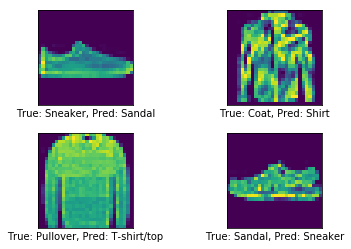

In [46]:
plot_example_errors()

[[881   3   5  24   4   0  66   0  16   1]
 [ 12 944   2  31   5   0   4   0   2   0]
 [ 43   0 489  12 248   1 198   0   9   0]
 [104  10   3 799  28   1  51   0   4   0]
 [  5   1  34  60 705   0 187   0   8   0]
 [  1   0   0   2   0 899   0  53   3  42]
 [252   1  81  19 103   0 518   0  26   0]
 [  0   0   0   0   0  24   0 863   1 112]
 [ 12   1   3   5   3   4  13   4 954   1]
 [  0   0   0   1   0   6   0  16   1 976]]


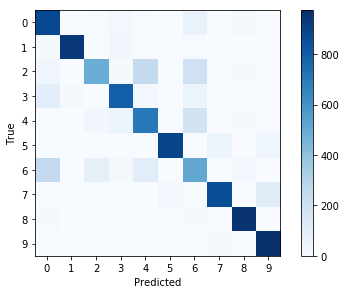

In [47]:
print_confusion_matrix()

### Performance after 10000 optimization iterations

In [48]:
optimize(iterations=10000)

0000 mse: 0.505
0100 mse: 0.333
0200 mse: 0.565
0300 mse: 0.430
0400 mse: 0.394
0500 mse: 0.514
0600 mse: 0.344
0700 mse: 0.438
0800 mse: 0.791
0900 mse: 0.561
1000 mse: 0.240
1100 mse: 0.377
1200 mse: 0.447
1300 mse: 0.405
1400 mse: 0.496
1500 mse: 0.328
1600 mse: 0.523
1700 mse: 0.379
1800 mse: 0.448
1900 mse: 0.481
2000 mse: 0.412
2100 mse: 0.477
2200 mse: 0.433
2300 mse: 0.368
2400 mse: 0.424
2500 mse: 0.256
2600 mse: 0.312
2700 mse: 0.450
2800 mse: 0.278
2900 mse: 0.419
3000 mse: 0.403
3100 mse: 0.299
3200 mse: 0.373
3300 mse: 0.481
3400 mse: 0.331
3500 mse: 0.443
3600 mse: 0.401
3700 mse: 0.366
3800 mse: 0.274
3900 mse: 0.414
4000 mse: 0.305
4100 mse: 0.412
4200 mse: 0.379
4300 mse: 0.264
4400 mse: 0.352
4500 mse: 0.347
4600 mse: 0.441
4700 mse: 0.414
4800 mse: 0.352
4900 mse: 0.410
5000 mse: 0.395
5100 mse: 0.396
5200 mse: 0.361
5300 mse: 0.376
5400 mse: 0.216
5500 mse: 0.333
5600 mse: 0.293
5700 mse: 0.278
5800 mse: 0.274
5900 mse: 0.193
6000 mse: 0.265
6100 mse: 0.313
6200 mse

In [49]:
print_accuracy()

Accuracy on test-set: 86.1%


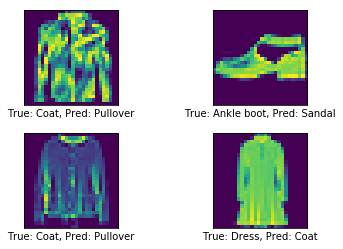

In [50]:
plot_example_errors()

[[783   2  15  43   9   1 132   0  14   1]
 [  0 964   0  21   7   1   4   0   2   1]
 [  8   0 732  13 137   0 100   1   9   0]
 [ 14   8   6 860  64   1  39   2   6   0]
 [  0   2  98  14 825   0  54   0   7   0]
 [  0   0   0   2   0 960   0  29   4   5]
 [120   1  71  30 104   1 658   0  15   0]
 [  0   0   0   0   0  31   0 957   1  11]
 [  2   1   2   4   6   5   8   5 967   0]
 [  0   0   0   1   0  29   0  66   1 903]]


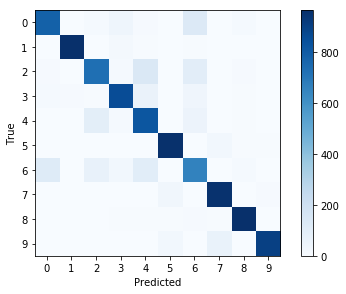

In [51]:
print_confusion_matrix()

### Conclusion
We can see from the resutls that achieving high accuracy on MNIST dataset was way easy. With simple two layer fully connected 40 layer neural network we were able to achieve accuracy around 97% after 10,000 epochs. Imagine if this was a complicated CNN then we can get more high accuracy. But in Fashion-MNIST case dataset contains many hard examples and many examples which are close to each other. By looking at the misclassified or the confusion matrix we can tell images for T-shirt/Top, Shirt, Coat, and Pullover are very close to each other and classifying them is tough. Even after 10,000 epochs we still only have 86% accuracy. 